# Universidad del Valle de Guatemala
## Security Data Science - 10
* Walter Danilo Saldaña Salguero - 19897
* Javier Alejandro Cotto Argueta - 19324

## Laboratorio 6: Clasificación de Malware con DL

Importamos librearias

In [9]:
from cv2 import imread, resize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

# Analisis Exploratorio

In [10]:
df = pd.read_csv('./data_imgs_malware.csv', encoding='utf8')

In [11]:
df.columns = ['ID', 'FamilyId', 'FamilyName', 'File', 'Path', 'Height', 'Width']

In [22]:
df.shape

(4909, 7)

In [12]:
df.sample(10)

,ID,FamilyId,FamilyName,File,Path,Height,Width
3374,9339,16,Malex.gen!J,004dbb473dd76ad6a63ab690f9b1d299.png,./malimg_paper_dataset_imgs/Malex.gen!J/004dbb...,368,256
2666,9339,11,Instantaccess,0801bb2e19d0979ed07986f564180c6b.png,./malimg_paper_dataset_imgs/Instantaccess/0801...,467,384
437,9339,2,Allaple.A,0062fef78a6d7a4f472b569056f1af97.png,./malimg_paper_dataset_imgs/Allaple.A/0062fef7...,284,256
4340,9339,22,VB.AT,02c1acf3e5674dcb879087523d83333f.png,./malimg_paper_dataset_imgs/VB.AT/02c1acf3e567...,773,768
2357,9339,11,Instantaccess,00fe07db86f76aeb4b9d13bcc7dfe156.png,./malimg_paper_dataset_imgs/Instantaccess/00fe...,445,384
1158,9339,5,Autorun.K,058889b7c82d6fe56e73ac12a4638bc0.png,./malimg_paper_dataset_imgs/Autorun.K/058889b7...,683,768
1320,9339,6,C2LOP.gen!g,05791628bbdc9c25d9c1a68e68c389c7.png,./malimg_paper_dataset_imgs/C2LOP.gen!g/057916...,983,512
1175,9339,5,Autorun.K,073bca61dc83d8c6a02a440b46527fe5.png,./malimg_paper_dataset_imgs/Autorun.K/073bca61...,683,768
171,9339,1,Agent.FYI,0095a73b6d04a452e6956e455d3b3229.png,./malimg_paper_dataset_imgs/Agent.FYI/0095a73b...,258,64
2193,9339,10,Fakerean,072cdedde800dc51392df3ccc02bf8f0.png,./malimg_paper_dataset_imgs/Fakerean/072cdedde...,277,384


### Datos estadisticos

In [5]:
df.describe()

,ID,FamilyId,Height,Width
count,4909.0,4909.000000,4909.000000,4909.000000
mean,9339.0,11.709717,487.606030,381.796700
std,0.0,7.159314,237.125521,231.194613
min,9339.0,0.000000,208.000000,64.000000
25%,9339.0,6.000000,306.000000,128.000000
50%,9339.0,11.000000,445.000000,384.000000
75%,9339.0,18.000000,639.000000,512.000000
max,9339.0,24.000000,5334.000000,1024.000000


In [13]:
#DIVIDIMOS DATA EN DOS CONJUNTOS
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
#PREPROCESAMOS IMAGENES
def preprocess_image(image_path, target_size):
    image = imread(image_path)
    resized_image = resize(image, target_size)
    return resized_image

target_height = 224
target_width = 224

train_data['image'] = train_data['Path'].apply(lambda x: preprocess_image(x, (target_height, target_width)))
test_data['image'] = test_data['Path'].apply(lambda x: preprocess_image(x, (target_height, target_width)))

In [15]:
from keras.utils import to_categorical
#PREPARAMOS LOS DATOS DE ENTRADA Y SALIDA PARA EVITAR PROBLEMAS DE TIPO
X_train = np.array(train_data['image'].tolist())
X_test = np.array(test_data['image'].tolist())

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['FamilyId'])
y_test = label_encoder.transform(test_data['FamilyId'])

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Imagenes

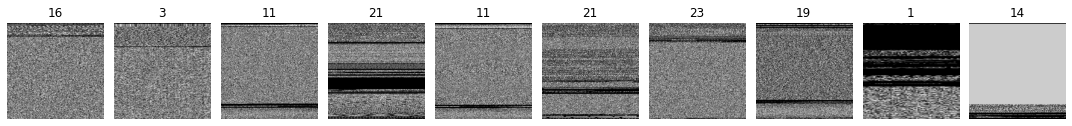

In [16]:
def visualize_images(images, labels, class_names, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_images(X_train, y_train.argmax(axis=1), label_encoder.classes_, n=10)

In [17]:
# Se limita el nivel de log de tensorflow para reducir la carga de procesamiento
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [14]:
#MODELO
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(target_height, target_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [16]:
#Compilamos el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

123/123 [==============================] - 588s 5s/step - loss: 32.5591 - accuracy: 0.6725 - val_loss: 1.1190 - val_accuracy: 0.7953


In [18]:
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)

31/31 [==============================] - 28s 905ms/step


In [19]:
y_pred_classes

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [20]:
accuracy = accuracy_score(y_pred_classes, y_test)
precision = precision_score(y_pred_classes, y_test, average='weighted')
recall = recall_score(y_pred_classes, y_test, average='weighted')
f1 = f1_score(y_pred_classes, y_test, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Accuracy:  0.6262729124236253
Precision:  0.9150280738226771
Recall:  0.9360730593607306
F1:  0.91678895127454


C:\Users\Javier Cotto\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


En este caso notamos métricas bastante pobres, a excepción de la precisión con un valor del 100%, sin embargo al revisar los valores predichos, se observa que todos son "1", por lo que es de esperarse que la precisión sea perfecta, pero no implica que el modelo este entrenado correctamente.

Prueba con otro modelo para mejorar resultados

## Guardamos Modelo y Conjuntos de Datos

In [6]:
imgs_reshaped = imgs.reshape(imgs.shape[0], imgs.shape[1], imgs.shape[2], 3)
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
model.save("Img_Class")

NameError: name 'imgs' is not defined